# Import

In [6]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import re
import torch
from tqdm.notebook import tqdm

# Load DataSet and Prepare

Не нашёл датасетов с описанием продукта, только с отзывом пользователя.

In [2]:
user_prompt = 'Howdy!'
system_prompt = 'You are a helpful assistant.'

B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
B_INST, E_INST = "[INST]", "[/INST]"

# Chat model prompt
prompt = f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{user_prompt.strip()} {E_INST}\n\n"

In [19]:
models_id = ['mistralai/Mistral-7B-Instruct-v0.2', 'google/gemma-7b-it', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-chat-hf']
context_length = [8192, 8192, 32000, 4096]

In [20]:
dataset = load_dataset("SetFit/amazon_reviews_multi_en")

df = pd.DataFrame.from_dict(data=dataset['train'])
df = df.sample(n=len(df))

In [22]:
df.head()

,id,text,label,label_text
150015,en_0855533,Haven't installed yet but looks great,3,3
130753,en_0210412,Liked a lot..will buy again!,3,3
61262,en_0234775,The jacket was too small and the pants was too...,1,1
79627,en_0138215,I purchased this set for a king size mattress....,1,1
97583,en_0440744,It's ok for what it is ...I would expect any l...,2,2


In [7]:
df['text'].iloc[8]

'Serves purpose but awkward and uncomfortable after a few mins.'

In [8]:
len(df), len(df['id'].unique())

(200000, 200000)

Создаём датафрейм со всеми лейблами для теста модели

In [9]:
batch_size_dict = 2
dict_label = {}
for label in df['label'].unique():
    df_label = df[df['label'] == label]
    dict_label.update({str(label): list(df_label['text'].iloc[:batch_size_dict])})
df_train = pd.DataFrame(data=dict_label)

# EDA

## Check data values

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  object
 1   text        200000 non-null  object
 2   label       200000 non-null  int64 
 3   label_text  200000 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


In [7]:
df_train['label'].unique(), df_train['label_text'].unique()

(array([0, 1, 2, 3, 4]), array(['0', '1', '2', '3', '4'], dtype=object))

## Check length data

In [8]:
len_text = np.array(df_train['text'].apply(lambda x: len(x)))

In [9]:
mean, median = np.mean(len_text), np.median(len_text)
print(f"mean - {mean}")
print(f"median - {median}")

mean - 178.84632
median - 125.0


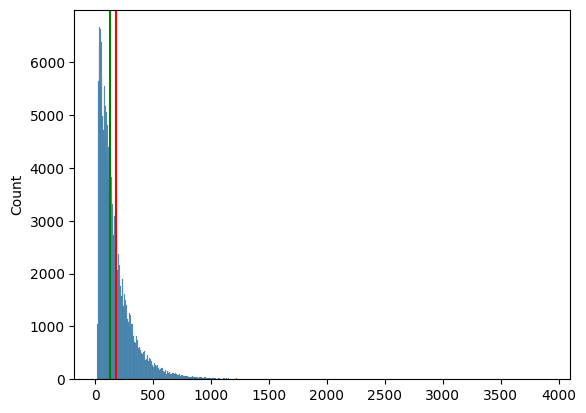

In [54]:
sns.histplot(x=len_text)
plt.axvline(x=mean, color='red')
plt.axvline(x=median, color='green')
plt.draw()

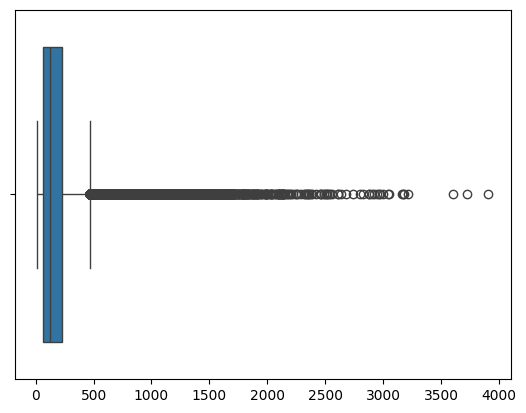

In [55]:
sns.boxplot(x=len_text)
plt.draw()

## Check tokens data

In [14]:
tokenizer('asfas asfas asfbdaf')

{'input_ids': [1, 390, 17284, 390, 17284, 390, 10967, 1705, 28722], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

model_id - mistralai/Mistral-7B-Instruct-v0.2
mean - 44.025215
median - 31.0

model_id - google/gemma-7b-it
mean - 41.40716
median - 29.0

model_id - mistralai/Mixtral-8x7B-Instruct-v0.1
mean - 44.025215
median - 31.0

model_id - meta-llama/Llama-2-7b-chat-hf
mean - 45.68618
median - 33.0



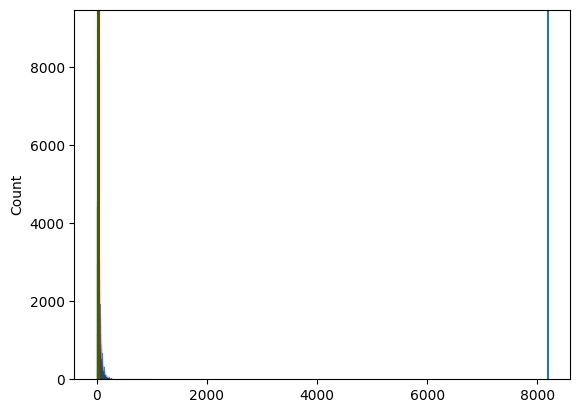

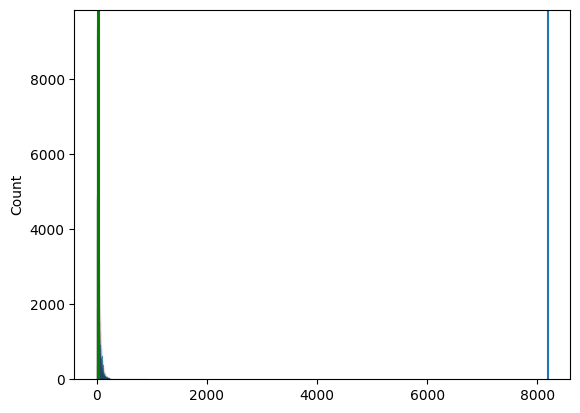

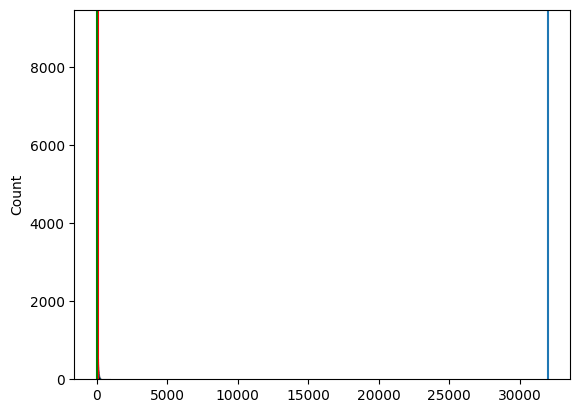

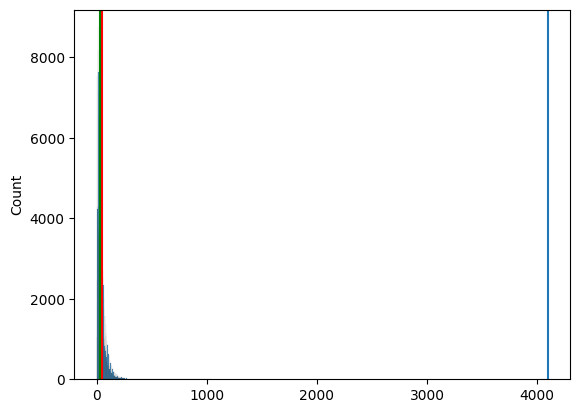

In [11]:
def get_count_tokens(tokenizer, text: str):
    return len(tokenizer(text)['input_ids'])

models_id = ['mistralai/Mistral-7B-Instruct-v0.2', 'google/gemma-7b-it', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-chat-hf']
context_length = [8192, 8192, 32000, 4096]

for i in range(len(models_id)):
    tokenizer = AutoTokenizer.from_pretrained(models_id[i])
    tokens_text = np.array(df_train['text'].apply(lambda x: get_count_tokens(tokenizer, x)))
    
    mean, median = np.mean(tokens_text), np.median(tokens_text)
    print(f"model_id - {models_id[i]}")
    print(f"mean - {mean}")
    print(f"median - {median}")
    print()
    
    plt.figure(i)    
    sns.histplot(x=tokens_text)
    plt.axvline(x=mean, color='red')
    plt.axvline(x=median, color='green')
    plt.axvline(x=context_length[i])
    plt.draw()

## Итог по EDA

Длина контекста каждой из модели позволяет засунуть текст в модель без обрезки контекста

# Clean Data

In [25]:
iters = 7
for i in range(iters):
    print(random.choice(list(df_train['text'])))
    print('-'*50)

We bought this specifically to use while we traveled over the holidays. It is nice and small which makes it easier to take with us and doesn't take as much room as a full size pack n play. I love the vibration features as well. My son was 2 months old when we used this and there wasn't too much room left for growing in the bassinet portion, which is fine since the rest of it is big enough for him to grow!
--------------------------------------------------
Not what inspect to get
--------------------------------------------------
Too small, would love this product if the trays held more pieces. Wish I had checked the size before purchase.
--------------------------------------------------
These jeans possess the ability to flex a bit, which is nice. They fit me well and make me look good. Their light weight makes them a good choice when I go out dancing. I like the smoke / charcoal color because I can pair them with black shoes for a more formal look, casual shoes for work, and running/

Посмотрев несколько раз глазами на рандномные семплы данных, мы можем увидеть, что данные чистые: без битовых символов, переносов и другого мусора.

# Solving problem

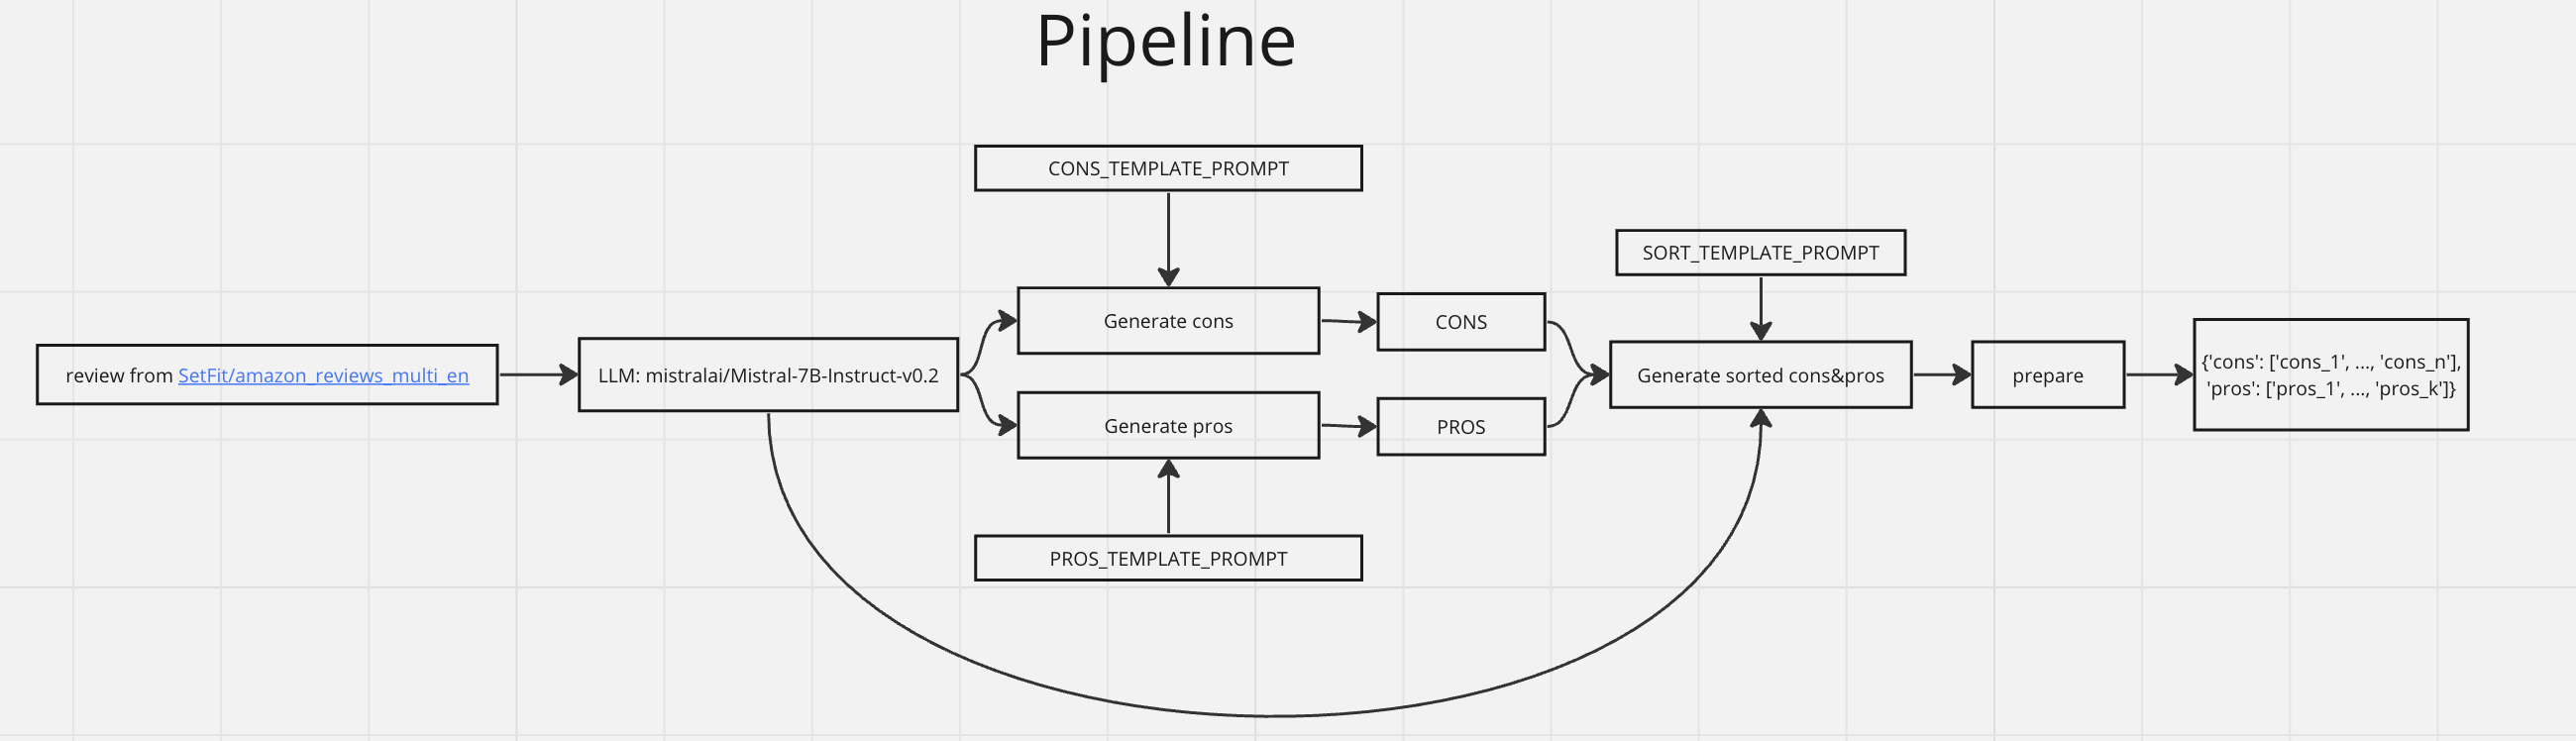


**Суть решения будет заключатся в том, что:**
1. Просим модель придумать плюсы, если их нет, то пусть напишет `No`.
2. Просим модель придумать минусы, если их нет, то пусть напишет `No`.
3. Попросим модель саму отсортировать плюсы и минусы, исходя из её прошлых генераций и отзыва пользователя.

## mistralai/Mistral-7B-Instruct-v0.2'

In [10]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
df_train

,4,3,1,2,0
0,Great fit. Easy to put on.,I love the characters and town the authors hav...,These SMELL. It's a very odd smell. I've no id...,I ordered the California King & it didn’t cove...,This app asks you to pay otherwise it loads th...
1,Love this quality product in gray.,Was a good read. Gives an American a glimpse o...,"The unit seemed to help. After several weeks, ...",Serves purpose but awkward and uncomfortable a...,Didn't last but a half a day


### Prompt-Tuning

Сгенерируем шаги оценивания с помощью модели. 

Пусть модель сама подумает, как ей оценивать плюсы и минусы.
`Идея взята из статьи про G-Eval и из здравого смысла, когда модели даём токены из своего же распределения`

In [54]:
pros_template_prompt = """You have been provided with a user review of the product. Please write down the benefits that you found in the review.
The answer should contain no more than 2-3 words of merit.
If you have not found any advantages, then do not try to come up with them, just return only the word "No"
Write the pros separated by commas: "word_1, word_2, word_3..."
Look at an example to better understand your task.

write down the steps as you would give the answer:"""

In [55]:
messages = [
    {"role": "user", "content": pros_template_prompt},
]
temperature = 0.7
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
outputs = model.generate(inputs, pad_token_id=2 ,temperature=temperature, max_new_tokens=1000, do_sample=True)
gen_output = tokenizer.decode(outputs[0, len(inputs[0]):], skip_special_tokens=True)

In [56]:
print(gen_output)

1. Read the user review thoroughly.
2. Identify the key words or phrases that suggest benefits.
3. Extract those benefits and write them as single words.
4. Separate the benefits with commas: "word_1, word_2, word_3..."

Review: "The product is extremely fast, efficient, and reliable. It has significantly improved my productivity."

Answer: fast, efficient, reliable, productivity.


In [94]:
cons_template_prompt = """You have been provided with a user review of the product. Please describe the cons that you found in the review.
The answer should contain no more than 2-3 words that describe the construction.
If you have not found any cons, then do not try to come up with them, just return only the word "No"
Write the pros separated by commas: "word_1, word_2, word_3..."
Look at an example to better understand your task.

write down the steps as you would give the answer:"""

In [95]:
messages = [
    {"role": "user", "content": cons_template_prompt},
]
temperature = 0.7
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
outputs = model.generate(inputs, pad_token_id=2 ,temperature=temperature, max_new_tokens=1000, do_sample=True)
gen_output = tokenizer.decode(outputs[0, len(inputs[0]):], skip_special_tokens=True)

In [96]:
print(gen_output)

1. Read the user review carefully.
2. Identify any cons related to construction mentioned.
3. If no cons are mentioned, return "No".
4. If cons are mentioned, write down the keywords that describe them.
5. Return the answer with the cons keywords.

Example:
User review: "I love the design of the product, but the plastic feels cheap and the stitching is coming undone."

Answer: "cheap plastic, coming undone stitching."

User review: "The product is well-made and I have had no issues with it."

Answer: "No"


### Pros-Prompt & Cons-Prompt

In [80]:
def get_generation_model(model, prompt: str, temperature: int, max_new_tokens: int) -> str:
    messages = [
        {"role": "user", "content": prompt},
    ]
    inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    outputs = model.generate(inputs, pad_token_id=2 ,temperature=temperature, max_new_tokens=max_new_tokens, do_sample=True)
    gen_output = tokenizer.decode(outputs[0, len(inputs[0]):], skip_special_tokens=True)
    return gen_output

In [81]:
pros_template_prompt = """You have been provided with a user review of the product. Please write down the benefits that you found in the review.
The answer should contain no more than 2-3 words of merit.
If you have not found any advantages, then do not try to come up with them, just return only the word "No".
Write the pros separated by commas: "word_1, word_2, word_3..."

Example 1:
Review: "Excellent value for money, well-made product, perfect for our coffee pot, for a small fraction of the cost of the same product in stores."
You answer (word_1, word_2, word_3...): "Good quality, competitive price"

Example 2:
"There is a terrible one band across the top. Supposed to keep the shirt on your shoulders but seems more of like a waistband."
You answer (word_1, word_2, word_3... or No): "No"

Your assessment steps:
1. Read the user review thoroughly.
2. Identify the key words or phrases that suggest benefits.
3. Extract those benefits and write them as single words.
4. Separate the benefits with commas: "word_1, word_2, word_3..."


Review:{review}

You answer (word_1, word_2, word_3...or No):"""

cons_template_prompt = """You have been provided with a user review of the product. Please describe the cons that you found in the review.
The answer should contain no more than 2-3 words that describe the construction.
If you have not found any cons, then do not try to come up with them, just return only the word "No"
Write the pros separated by commas: "word_1, word_2, word_3..."
Look at an example to better understand your task.

Example 1:
"There is a terrible one band across the top. Supposed to keep the shirt on your shoulders but seems more of like a waistband."
You answer (word_1, word_2, word_3... or No): "Terrible streak, not the right size"

Example 2:
Review: "Excellent value for money, well-made product, perfect for our coffee pot, for a small fraction of the cost of the same product in stores."
You answer (word_1, word_2, word_3...): "No"

Your assessment steps:
1. Read the user review carefully.
2. Identify any cons related to construction mentioned.
3. If no cons are mentioned, return "No".
4. If cons are mentioned, write down the keywords that describe them.
5. Return the answer with the cons keywords.


Review:{review}

You answer (word_1, word_2, word_3...or No):"""

**Плюсы отзыва**

In [82]:
max_new_tokens = 20
temperature = 0.7

In [83]:
pros_output_lst = []
for column in list(df_train.columns):
    for review in list(df_train[column]):
        prompt = pros_template_prompt.format(review=review)
        gen_output = get_generation_model(model, prompt, temperature, max_new_tokens)
        print(f"label - {column}")
        print(f'review - {review}')
        print(f"gen_output - {gen_output}")
        print('-'*50)
        pros_output_lst.append(gen_output)

label - 4
review - Great fit. Easy to put on.
gen_output - Comfortable, Easy to wear
--------------------------------------------------
label - 4
review - Love this quality product in gray.
gen_output - Love, quality [Pro tip: Always consider the context of the word in the sentence to ensure it
--------------------------------------------------
label - 3
review - I love the characters and town the authors have created. My favorite thing is the relationship between Cee-cee and her sisters. Great to read about a middle aged woman finding her truth and living her best life!
gen_output - Enjoyable characters, Strong relationship, Middle-aged woman, Living best life.
--------------------------------------------------
label - 3
review - Was a good read. Gives an American a glimpse of British life. Had lots of terms and phrases that we don't use, but could easily figure out. The dry sense of humor was very appealing to me.
gen_output - Entertaining, Cultural insight, Clear understanding.
----

**Минусы отзыва**

In [84]:
cons_output_lst = []
reviews = []
for column in list(df_train.columns):
    for review in list(df_train[column]):
        prompt = cons_template_prompt.format(review=review)
        gen_output = get_generation_model(model, prompt, temperature, max_new_tokens)
        print(f"label - {column}")
        print(f'review - {review}')
        print(f"gen_output - {gen_output}")
        print('-'*50)
        cons_output_lst.append(gen_output)
        reviews.append(review)

label - 4
review - Great fit. Easy to put on.
gen_output - No.
--------------------------------------------------
label - 4
review - Love this quality product in gray.
gen_output - No.
--------------------------------------------------
label - 3
review - I love the characters and town the authors have created. My favorite thing is the relationship between Cee-cee and her sisters. Great to read about a middle aged woman finding her truth and living her best life!
gen_output - No.
--------------------------------------------------
label - 3
review - Was a good read. Gives an American a glimpse of British life. Had lots of terms and phrases that we don't use, but could easily figure out. The dry sense of humor was very appealing to me.
gen_output - No.
--------------------------------------------------
label - 1
review - These SMELL. It's a very odd smell. I've no idea why they smell so bad/weird, but I'm hoping it goes away, as I threw the box away due to the fact that we we're moving an

`label` - это оценка пользователя

`review` - отзыв пользователя

`gen_output` - генерация модели

**Вывод:** 
1. Модель возвращает `No`, когда `label` равен 1, 2, 3 для положительных и `No` для 3, 4 для отрицательных - это **хорошо**, так как модель понимает, что мы от неё просим. Но при этом она может найти определённые плюсы, поэтому стоит **сделать постобработку**

### PostProccesing

In [85]:
def extract_text(text):
    # Remove text inside parentheses and surrounding spaces
    text = re.sub(r'\n.*', '', text)
    text = re.sub(r'\s*\([^)]*\)\s*', '', text)
    text = re.sub(r'\[.*', '', text)
    text = text.replace('"', '')
    text = text.replace('You answer', '')
    text = text.replace('\n', '')
    text = text.replace('Review', '')
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('.', '')
    # Split text by comma and remove leading/trailing whitespace
    lst_text = [item.strip().lower() for item in text.split(',')]
    if len(lst_text) == lst_text.count('no'):
        return ['']
    else:
        lst_text = [item for item in lst_text if item != 'no']
    lst_text = list(dict.fromkeys(lst_text))
        
    return lst_text

In [86]:
clean_pros = []
for gen in pros_output_lst:
    extr_txt = extract_text(gen)
    clean_pros.append(extr_txt)
    
    print(extract_text(gen))
    print('-'*50)

['comfortable', 'easy to wear']
--------------------------------------------------
['love', 'quality']
--------------------------------------------------
['enjoyable characters', 'strong relationship', 'middle-aged woman', 'living best life']
--------------------------------------------------
['entertaining', 'cultural insight', 'clear understanding']
--------------------------------------------------
['']
--------------------------------------------------
['']
--------------------------------------------------
['']
--------------------------------------------------
['serves purpose', 'awkward', 'uncomfortable']
--------------------------------------------------
['']
--------------------------------------------------
['']
--------------------------------------------------


In [87]:
clean_cons = []

for gen in cons_output_lst:
    extr_txt = extract_text(gen)
    clean_cons.append(extr_txt)
    
    print(extract_text(gen))
    print('-'*50)

['']
--------------------------------------------------
['']
--------------------------------------------------
['']
--------------------------------------------------
['']
--------------------------------------------------
['weak', 'odd smell']
--------------------------------------------------
['fingers broke', 'unit trashed']
--------------------------------------------------
['short', 'not wide enough']
--------------------------------------------------
['awkward', 'uncomfortable']
--------------------------------------------------
['paywall', 'no construction cons mentioned in the review']
--------------------------------------------------
['low durability']
--------------------------------------------------


### Merge Result and Return Pros&Cons

In [88]:
proc_cons_lst = []
for i in range(len(clean_cons)):
    pros = clean_pros[i]
    cons = clean_cons[i]
    
    proc_cons = pros + cons
    proc_cons = list(dict.fromkeys(proc_cons))
    proc_cons_lst.append(", ".join(proc_cons))
    print(", ".join(proc_cons))
    print('-'*50)
    
    

comfortable, easy to wear, 
--------------------------------------------------
love, quality, 
--------------------------------------------------
enjoyable characters, strong relationship, middle-aged woman, living best life, 
--------------------------------------------------
entertaining, cultural insight, clear understanding, 
--------------------------------------------------
, weak, odd smell
--------------------------------------------------
, fingers broke, unit trashed
--------------------------------------------------
, short, not wide enough
--------------------------------------------------
serves purpose, awkward, uncomfortable
--------------------------------------------------
, paywall, no construction cons mentioned in the review
--------------------------------------------------
, low durability
--------------------------------------------------


In [89]:
cons_template_prompt = """1. You will be given the words, please divide them into pros and cons. 
2. Don't add unnecessary words.
3. If there are no pros, then write in Answer "Pros: No".
3. If there are no cons, then write in Answer "Cons: No".

Example 1:
Words: 'good sound quality, affordable, includes pouch and cable, terrible quality'
Answer: 'Pros: good sound quality, affordable, includes pouch and cable', 'Cons: terrible quality'

Example 2:
Words: 'powerful, heavy, longer cord, suction, crevasse tool, , shorter cloth bag, harder to clean'
Answer: 'Pros: powerful, longer cord, includes suction and crevasse tool', 'Cons: heavy, shorter cloth bag, harder to clean'

Example 3:
Words: 'comfortable, attractive, offers support, variety'
Answer: 'Pros: comfortable, attractive, offers support, variety', 'Cons: No'

Example 4:
Words: 'defective product, unsatisfied customer, broken legs, manufacturer defect'
Answer: 'Pros: defective product, unsatisfied customer, broken legs, manufacturer defect', 'Cons: defective product'


Words: '{pros_cons}'
Answer:"""

In [90]:
proc_cons_lst

['comfortable, easy to wear, ',
 'love, quality, ',
 'enjoyable characters, strong relationship, middle-aged woman, living best life, ',
 'entertaining, cultural insight, clear understanding, ',
 ', weak, odd smell',
 ', fingers broke, unit trashed',
 ', short, not wide enough',
 'serves purpose, awkward, uncomfortable',
 ', paywall, no construction cons mentioned in the review',
 ', low durability']

In [91]:
temperature, max_new_tokens = 0.2, 50

In [92]:
def parse_reviews(input_str):
    review_dict = {"pros": [], "cons": []}
    input_str = input_str.replace('\n', ',', 1)
    input_str = input_str.replace('\n', '', )
    input_str = input_str.replace("'", '', )
    input_str = input_str.lower()
    group_pros = re.findall(r'pros: (.*)[ ,]?cons', input_str)
    text = input_str
    pros = []
    cons = []

    if text.find("pros:") < text.find("cons:"):
        pros_section, cons_section = text.split("cons:")
    else:
        cons_section, pros_section = text.split("pros:")
    pros = [item.strip() for item in pros_section.split(",")]
    cons = [item.strip() for item in cons_section.split(",")]
    cons = [item.lower().capitalize() for item in cons]
    
    dict_cp = {"pros": pros, "cons": cons}
    cleand_pros = []
    cleand_cons = []
    
    for i in range(len(pros)):
        pros[i] = pros[i].lower()
        pros[i] = pros[i].replace('pros:', '')
        pros[i] = pros[i].replace('words:', '')
        pros[i] = pros[i].replace('.', '')
        pros[i] = pros[i].strip()
        if pros[i] != '':
            cleand_pros.append(pros[i])
            
    for i in range(len(cons)):
        cons[i] = cons[i].lower()
        cons[i] = cons[i].replace('cons:', '')
        cons[i] = cons[i].replace('words:', '')
        cons[i] = cons[i].replace('.', '')
        cons[i] = cons[i].strip()
        if cons[i] != '':
            cleand_cons.append(cons[i])
            
    if len(cleand_pros) == 0:
        cleand_pros.append('no')
        
    if len(cleand_cons) == 0:
        cleand_cons.append('no')
        
    return {"pros": cleand_pros, "cons": cleand_cons}

In [75]:
for proc_cons_output in proc_cons_output_lst:
    print(parse_reviews(proc_cons_output))
    print('-'*50)

{'pros': ['comfortable', 'convenient'], 'cons': ['no']}
--------------------------------------------------
{'pros': ['love', 'quality'], 'cons': ['no']}
--------------------------------------------------
{'pros': ['enjoyable characters', 'finding truth', 'best life'], 'cons': ['middle-aged woman', 'no (assuming theres no inherent con to being a middle-aged woman)']}
--------------------------------------------------
{'pros': ['entertaining', 'provides cultural insight', 'clear understanding'], 'cons': ['no']}
--------------------------------------------------
{'pros': ['not strong'], 'cons': ['odd smell']}
--------------------------------------------------
{'pros': ['no'], 'cons': ['fingers broke', 'unit trashed']}
--------------------------------------------------
{'pros': ['no'], 'cons': ['short', 'not long enough']}
--------------------------------------------------
{'pros': ['no'], 'cons': ['awkward', 'uncomfortable']}
--------------------------------------------------
{'pros': ['n

In [96]:
proc_cons_output_lst = []
proc_cons_output = []
for i in range(len(proc_cons_lst)):
    proc_cons = proc_cons_lst[i]
    review = reviews[i]
    proc_cons_prompt = cons_template_prompt.format(pros_cons=proc_cons)    
    gen_output = get_generation_model(model, prompt=proc_cons_prompt, temperature=temperature, max_new_tokens=max_new_tokens)
    print()
    print(f"gen_output - {gen_output}")
    print(f"review - {review}")
    print('-'*50)
    parse_review = parse_reviews(gen_output)
    parse_review['review'] = review
    proc_cons_output.append(parse_review)
    proc_cons_output_lst.append(gen_output)
    


gen_output - 'Pros: comfortable, easy to wear', 'Cons: No'
review - Great fit. Easy to put on.
--------------------------------------------------

gen_output - Pros: love, quality
Cons: No.
review - Love this quality product in gray.
--------------------------------------------------

gen_output - 'Pros: enjoyable characters, strong relationship, middle-aged woman living best life', 'Cons: No'
review - I love the characters and town the authors have created. My favorite thing is the relationship between Cee-cee and her sisters. Great to read about a middle aged woman finding her truth and living her best life!
--------------------------------------------------

gen_output - 'Pros: entertaining, provides cultural insight, clear understanding', 'Cons: No'
review - Was a good read. Gives an American a glimpse of British life. Had lots of terms and phrases that we don't use, but could easily figure out. The dry sense of humor was very appealing to me.
-------------------------------------

In [97]:
proc_cons_output

[{'pros': ['comfortable', 'easy to wear'],
  'cons': ['no'],
  'review': 'Great fit. Easy to put on.'},
 {'pros': ['love', 'quality'],
  'cons': ['no'],
  'review': 'Love this quality product in gray.'},
 {'pros': ['enjoyable characters',
   'strong relationship',
   'middle-aged woman living best life'],
  'cons': ['no'],
  'review': 'I love the characters and town the authors have created. My favorite thing is the relationship between Cee-cee and her sisters. Great to read about a middle aged woman finding her truth and living her best life!'},
 {'pros': ['entertaining', 'provides cultural insight', 'clear understanding'],
  'cons': ['no'],
  'review': "Was a good read. Gives an American a glimpse of British life. Had lots of terms and phrases that we don't use, but could easily figure out. The dry sense of humor was very appealing to me."},
 {'pros': ['no'],
  'cons': ['weak', 'odd smell'],
  'review': "These SMELL. It's a very odd smell. I've no idea why they smell so bad/weird, bu

**Примеры оценки**:

1. `review` - "Didn't last but a half a day"
2. `pros`: 'no',
3. `cons`: 'low durability'

**Итог:** В фразе сказано, что *'Продержалось не более полдня'*, результат выдал в недостатках *'низкая долговечность'* - **модель поняла минус, который явно не изображен в комментарии**

1. `review` - "Serves purpose but awkward and uncomfortable after a few mins."
2. `pros`: 'serves purpose',
3. `cons`: 'awkward, uncomfortable'

**Итог:** В фразе сказано, что *'Служит цели, но через несколько минут становится неловко и неудобно'*, результат выдал в недостатках *'неудобно и некомфортно'*, но в плюсах выдал  *'выполняет свою задачу'*  - **модель понимает не явные плюсы и минусы в комментарии**

# Examples

В качестве метрики я выбрал G-Eval на моделе `mistralai/Mistral-7B-Instruct-v0.2`

In [21]:
from datasets import load_dataset
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import re
import torch
import pandas as pd

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

GEVAL_TEMPLATE_PROMPT = """
You will be given a review and its pros and cons, which are generated by the model.
Your task is to evaluate how the model generated the pros and cons according to the review.
Please make sure that you have read and understood this review carefully.
Please keep this document in mind during the assessment and refer to it if necessary. 
If there is the word 'No' in the pros or cons, it means that the model has not found the pros or cons.
It is very important, there may be a completely different wording in the review than in the pros and cons, do not pay attention to it
Don't be too strict, but give me a fair assessment.
The score can be from 1 to 5.
Score is the quality of how well the generated pros and cons reflect the content and key points of the review provided.
Score 1 - The generated pros and cons are unrelated to the content of the review or poorly reflect its key points.
Score 2 - Some of the generated pros and cons reflect elements mentioned in the review, but many important points are missed or inaccurately represented.
Score 3 - The majority of the generated pros and cons reflect elements mentioned in the review, but there are some inaccuracies or omissions.
Score 4 - The generated pros and cons closely reflect the content of the review, capturing most of the important points accurately.
Score 5 - The generated pros and cons accurately and comprehensively reflect the content of the review, capturing all important points with precision.

Example 1:
review: This was a very informative book. Not a novel but still very engaging. did not know their influence in many areas of things we take for granted.
pros: Informative, Engaging, Eye-opening
cons: No
Score: 5

Example 2:
review = Not nice quality but cute print.
pros = Cute print
cons = Bad quality
Score: 5

Example 3:
Review: This smartphone offers excellent performance and a sleek design. The display is vibrant and sharp, making it perfect for multimedia consumption. The battery life is decent, lasting through a full day of moderate usage. However, the camera quality could be improved, especially in low-light conditions. Overall, it's a solid choice for those seeking a reliable and stylish device.
Pros: Excellent performance, Sleek design, Vibrant display, Decent battery life
Cons: Camera quality in low-light conditions could be improved
Score: 4

Example 4:
review: I bought this as a gift and on sale - they loved how this comes with a tote. The tools feel well made and it has a great variety of items.
pros = Sale, Tote, Well made, Variety
cons = Not durable, Limited functionality, Poor quality
Score: 3

Example 5:
Review: This toaster fails to toast bread properly. The control buttons are too complicated to use, and the instructions don't help to figure it out. There are frequent malfunctions, leading to improper toasting or breakdowns. Additionally, the design is too bulky and takes up a lot of space on the kitchen countertop.
Pros: Sleek design, Easy to use controls, Reliable performance
Cons: Comfortable, Cute
Score: 1

In the answer, write only the number, only 1, 2, 3, 4 or 5 without explanations and unnecessary words.

Steps in evaluating the content of a model generation:
1. Read the review carefully to identify its key points and understand the reviewer's opinion.
2. Evaluate the pros and cons generated by the model to determine how well they reflect the content and key points of the review.
3. Compare the pros and cons to the review, focusing on the accuracy, comprehensiveness, and relevance of each point.
4. Assign a score based on the quality of the generated pros and cons, using the given scale (1-5) to indicate how closely they reflect the review.


Review: {review}
Pros: {pros}
Cons: {cons}
Score (write only 1, 2, 3, 4, or 5):
"""

class GEval:
    """
    Класс GEval предназначен для оценки сгенерированного текста с использованием предобученной языковой модели.
    
    Атрибуты:
        model (AutoModelForCausalLM): Экземпляр предобученной языковой модели для генерации текста.
        tokenizer (AutoTokenizer): Токенизатор, соответствующий модели, для преобразования текста в токены и обратно.
        score_tokens (list[int]): Список идентификаторов токенов, используемых для оценки сгенерированного текста.
        weight_tokens (torch.tensor): Веса, соответствующие токенам оценок, для вычисления итогового балла.
        
    Методы:
        init(self, model_name: str):
            Инициализирует экземпляр класса, загружая модель и токенизатор по указанному имени модели.
            
        find_tokens(self, generated_tokens: list, score_tokens: list) -> list:
            Возвращает индексы токенов из списка generated_tokens, которые присутствуют в списке score_tokens.
            
        predict(self, review: str) -> float:
            Генерирует продолжение текста на основе входного примера review и вычисляет итоговый балл сгенерированного текста.
    
    Пример использования:
        # Инициализация оценщика с предобученной моделью
        g_eval = GEval('gpt2')
        
        # Оценка сгенерированного текста
        score = g_eval.predict("Пример текста для генерации.")
        
        print(f"Итоговый балл: {score}")
    """

    def __init__(self, model_name: str):
        """
        Инициализирует экземпляр класса GEval.
        
        Аргументы:
            model_name (str): Имя предобученной модели, которая будет использоваться для генерации текста.
        """

        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.score_tokens = self.tokenizer.convert_tokens_to_ids(['1', '2', '3', '4', '5'])
        self.weight_tokens = torch.tensor([1., 2., 3., 4., 5.])
        
    def find_tokens(self, generated_tokens: list, score_tokens: list):
        """
        Находит индексы токенов из списка score_tokens в списке generated_tokens.
        
        Аргументы:
            generated_tokens (list): Список идентификаторов сгенерированных токенов.
            score_tokens (list): Список идентификаторов токенов оценок.
        
        Возвращает:
            list: Список индексов токенов оценок в сгенерированном тексте.
        """

        indexies = []
        for i in range(len(generated_tokens)):
            id_token = generated_tokens[i]
            for id_score_token in score_tokens:
                if id_token == id_score_token:
                    indexies.append(i)
        return indexies
        
    def predict(self, review: str, pros: str, cons: str) -> float:
        """
        Генерирует продолжение текста на основе входного примера и вычисляет итоговый балл сгенерированного текста.
        
        Аргументы:
            review (str): Текст, на основе которого будет сгенерировано продолжение.
        
        Возвращает:
            float: Итоговый балл сгенерированного текста.
        """

        prompt = GEVAL_TEMPLATE_PROMPT.format(review=review, pros=pros, cons=cons)
        
        messages = [
            {"role": "user", "content": prompt}
        ]
        
        encodeds = self.tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to(self.model.device)
        
        generation = self.model.generate(model_inputs, 
                               max_new_tokens=25, 
                               pad_token_id=self.tokenizer.eos_token_id,
                               output_scores=True,
                               return_dict_in_generate=True,
                               do_sample=False)
        
        generated_ids = generation['sequences']
        all_logits = generation['scores']
        generated_tokens = generated_ids[:, len(model_inputs[0]):][0].tolist()
        decoded = self.tokenizer.batch_decode(generated_ids)
        ids = self.find_tokens(generated_tokens, self.score_tokens)
        try:
            logits_token = all_logits[ids[0] - 1][0]
        except:
            logits_token = all_logits[-1]
            
        log_probs = torch.nn.functional.softmax(logits_token[self.score_tokens], dim=0).detach().cpu()
        score = torch.dot(log_probs, self.weight_tokens).item()
        return score
    
    def get_generation(self, review: str, pros: str, cons: str):
        prompt = GEVAL_TEMPLATE_PROMPT.format(review=review, pros=pros, cons=cons)
        
        messages = [
            {"role": "user", "content": prompt}
        ]
        
        encodeds = self.tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to(self.model.device)
        
        generation = self.model.generate(model_inputs, 
                               max_new_tokens=25, 
                               pad_token_id=self.tokenizer.eos_token_id,
                               output_scores=True,
                               return_dict_in_generate=True,
                               do_sample=False)
        all_logits = generation['scores']
        generated_ids = generation['sequences']
        generated_tokens = generated_ids[:, len(model_inputs[0]):][0].tolist()
        decoded = self.tokenizer.batch_decode(generated_tokens)
        return decoded

PROS_TEMPLATE_PROMPT = """You have been provided with a user review of the product. Please write down the benefits that you found in the review.
The answer should contain no more than 2-3 words of merit.
If you have not found any advantages, then do not try to come up with them, just return only the word "No".
Write the pros separated by commas: "word_1, word_2, word_3..."

Example 1:
Review: "Excellent value for money, well-made product, perfect for our coffee pot, for a small fraction of the cost of the same product in stores."
You answer (word_1, word_2, word_3...): "Good quality, competitive price"

Example 2:
"There is a terrible one band across the top. Supposed to keep the shirt on your shoulders but seems more of like a waistband."
You answer (word_1, word_2, word_3... or No): "No"

Your assessment steps:
1. Read the user review thoroughly.
2. Identify the key words or phrases that suggest benefits.
3. Extract those benefits and write them as single words.
4. Separate the benefits with commas: "word_1, word_2, word_3..."


Review:{review}

You answer (word_1, word_2, word_3...or No):"""

CONS_TEMPLATE_PROMPT = """You have been provided with a user review of the product. Please describe the cons that you found in the review.
The answer should contain no more than 2-3 words that describe the construction.
If you have not found any cons, then do not try to come up with them, just return only the word "No"
Write the pros separated by commas: "word_1, word_2, word_3..."
Look at an example to better understand your task.

Example 1:
"There is a terrible one band across the top. Supposed to keep the shirt on your shoulders but seems more of like a waistband."
You answer (word_1, word_2, word_3... or No): "Terrible streak, not the right size"

Example 2:
Review: "Excellent value for money, well-made product, perfect for our coffee pot, for a small fraction of the cost of the same product in stores."
You answer (word_1, word_2, word_3...): "No"

Your assessment steps:
1. Read the user review carefully.
2. Identify any cons related to construction mentioned.
3. If no cons are mentioned, return "No".
4. If cons are mentioned, write down the keywords that describe them.
5. Return the answer with the cons keywords.


Review:{review}

You answer (word_1, word_2, word_3...or No):"""

SORT_TEMPLATE_PROMPT = """1. You will be given the words, please divide them into pros and cons. 
2. Don't add unnecessary words.
3. If there are no pros, then write in Answer "Pros: No".
3. If there are no cons, then write in Answer "Cons: No".

Example 1:
Words: 'good sound quality, affordable, includes pouch and cable, terrible quality'
Answer: 'Pros: good sound quality, affordable, includes pouch and cable', 'Cons: terrible quality'

Example 2:
Words: 'powerful, heavy, longer cord, suction, crevasse tool, , shorter cloth bag, harder to clean'
Answer: 'Pros: powerful, longer cord, includes suction and crevasse tool', 'Cons: heavy, shorter cloth bag, harder to clean'

Example 3:
Words: 'comfortable, attractive, offers support, variety'
Answer: 'Pros: comfortable, attractive, offers support, variety', 'Cons: No'

Example 4:
Words: 'defective product, unsatisfied customer, broken legs, manufacturer defect'
Answer: 'Pros: defective product, unsatisfied customer, broken legs, manufacturer defect', 'Cons: defective product'


Words: '{pros_cons}'
Answer:"""


class CPModel:
    """
    Класс для суммаризации отзывов на товары с целью извлечения плюсов и минусов.
    
    Параметры:
    - model_name: str - имя или путь к предварительно обученной модели трансформера.
    
    Атрибуты:
    - cp_temperature: float - температура для генерации плюсов и минусов.
    - sort_temperature: float - температура для сортировки плюсов и минусов.
    - cp_max_new_tokens: int - максимальное количество новых токенов для генерации плюсов и минусов.
    - sort_max_new_tokens: int - максимальное количество новых токенов для сортировки плюсов и минусов.
    - tokenizer: AutoTokenizer - токенизатор из библиотеки transformers.
    - model: AutoModelForCausalLM - модель для каузального языкового моделирования из библиотеки transformers.
    """

    def __init__(self, model_name: str):
        """
        Инициализирует модель с заданными параметрами.
        """

        self.cp_temperature = 0.7
        self.sort_temperature = 0.2

        self.cp_max_new_tokens = 20
        self.sort_max_new_tokens = 50
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype = torch.float16)
    
    def get_generation_model(self, prompt: str, temperature: float, max_new_tokens: int) -> str:
        """
        Генерирует текст на основе заданного запроса.
        
        Параметры:
        - prompt: str - текст запроса для генерации.
        - temperature: float - температура для генерации текста.
        - max_new_tokens: int - максимальное количество новых токенов для генерации.
        
        Возвращает:
        - Строка сгенерированного текста.
        """

        messages = [
            {"role": "user", "content": prompt},
        ]
        inputs = self.tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
        outputs = self.model.generate(inputs, pad_token_id=2 ,temperature=temperature, max_new_tokens=max_new_tokens, do_sample=True)
        gen_output = self.tokenizer.decode(outputs[0, len(inputs[0]):], skip_special_tokens=True)
        return gen_output
    
    def get_generation_cons(self, review: str) -> list[str]:
        """
        Генерирует список минусов из отзыва.
        
        Параметры:
        - review: str - текст отзыва.
        
        Возвращает:
        - Список строк с минусами.
        """

        prompt = CONS_TEMPLATE_PROMPT.format(review=review)
        gen_output = self.get_generation_model(prompt, temperature=self.cp_temperature, max_new_tokens=self.cp_max_new_tokens)
        extract_get = self.extract_text(gen_output)
        return extract_get

    def get_generation_pros(self, review: str) -> list[str]:
        """
        Генерирует список плюсов из отзыва.
        
        Параметры:
        - review: str - текст отзыва.
        
        Возвращает:
        - Список строк с плюсами.
        """

        prompt = PROS_TEMPLATE_PROMPT.format(review=review)
        gen_output = self.get_generation_model(prompt, temperature=self.cp_temperature, max_new_tokens=self.cp_max_new_tokens)
        extract_get = self.extract_text(gen_output)
        return extract_get
    
    def get_generation_sort_cp(self, pros: list, cons: list) -> dict:
        """
        Сортирует и объединяет плюсы и минусы в один словарь.
        
        Параметры:
        - pros: list - список плюсов.
        - cons: list - список минусов.
        
        Возвращает:
        - Словарь с ключами 'pros' и 'cons', содержащий отсортированные списки плюсов и минусов.
        """

        proc_cons = pros + cons
        proc_cons = list(dict.fromkeys(proc_cons))
        proc_cons = ", ".join(proc_cons)
        
        proc_cons_prompt = SORT_TEMPLATE_PROMPT.format(pros_cons=proc_cons)  
        gen_output = self.get_generation_model(proc_cons_prompt, temperature=self.sort_temperature, max_new_tokens=self.sort_max_new_tokens)
        dict_gen = self.parse_reviews(gen_output)
        return dict_gen
        
    def predict(self, reviews: list[str]) -> list[dict[str]]:
        """
        Производит предсказание плюсов и минусов для списка отзывов.
        
        Параметры:
        - reviews: list[str] - список текстов отзывов.
        
        Возвращает:
        - Список словарей с ключами 'pros', 'cons' и 'review', содержащих информацию о плюсах, минусах и самом отзыве.
        """

        gen_lst = []
        for review in reviews:
            cons = self.get_generation_cons(review)
            pros = self.get_generation_pros(review)
            dict_gen = self.get_generation_sort_cp(pros=pros, cons=cons)
            dict_gen['review'] = review
            gen_lst.append(dict_gen)
        return gen_lst
    
    def extract_text(self, text: str) -> list[str]:
        """
        Очищает и обрабатывает текст для дальнейшего использования.
        
        Параметры:
        - text: str - текст для обработки.
        
        Возвращает:
        - Список строк после очистки и обработки текста.
        """

        text = re.sub(r'\n.*', '', text)
        text = re.sub(r'\s*\([^)]*\)\s*', '', text)
        text = re.sub(r'\[.*', '', text)
        text = text.replace('"', '')
        text = text.replace('You answer', '')
        text = text.replace('\n', '')
        text = text.replace('Review', '')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('.', '')
        lst_text = [item.strip().lower() for item in text.split(',')]
        if len(lst_text) == lst_text.count('no'):
            return ['']
        else:
            lst_text = [item for item in lst_text if item != 'no']
        lst_text = list(dict.fromkeys(lst_text))

        return lst_text
    
    def parse_reviews(self, input_str: str) -> dict[str]:
        """
        Разбирает строку на плюсы и минусы и возвращает их в виде словаря.

        Параметры:
        - input_str: str - строка для разбора.

        Возвращает:
        - Словарь с ключами 'pros' и 'cons', содержащий списки плюсов и минусов соответственно.
        """

        # Приведение всего текста к нижнему регистру и удаление нежелательных символов
        input_str = input_str.lower().replace("'", "").replace(".", "")

        # Извлечение разделов "pros" и "cons"
        pros_text = cons_text = ''
        if "pros:" in input_str and "cons:" in input_str:
            if input_str.find("pros:") < input_str.find("cons:"):
                pros_text, cons_text = re.split("cons:", input_str, 1)
            else:
                cons_text, pros_text = re.split("pros:", input_str, 1)
        pros_text = pros_text.replace("pros:", "")
        cons_text = cons_text.replace("cons:", "")

        # Очистка и разделение на элементы
        clean_pros = [item.strip().capitalize() for item in pros_text.split(",") if item.strip()]
        clean_cons = [item.strip().capitalize() for item in cons_text.split(",") if item.strip()]

        # Обработка случая, когда список пуст
        if not clean_pros:
            clean_pros.append('No')
        if not clean_cons:
            clean_cons.append('No')

        return {"pros": clean_pros, "cons": clean_cons}

In [22]:
reviews = []
dataset = load_dataset("SetFit/amazon_reviews_multi_en")

df = pd.DataFrame.from_dict(data=dataset['train'])
df = df.sample(n=len(df))

batch_size_dict = 2
dict_label = {}
for label in df['label'].unique():
    df_label = df[df['label'] == label]
    review_lst = list(df_label['text'].iloc[:batch_size_dict])
    for review in review_lst:
        reviews.append(review)

In [23]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
cpmodel = CPModel(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
geval = GEval(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
predicts = cpmodel.predict(reviews)

In [27]:
for dct in predicts:
    print(f"review = '{dct['review']}'")
    print()
    print(f"pros = '{dct['pros']}'")
    print(f"cons = '{dct['cons']}'")
    
    review = dct['review']
    pros = ", ".join(dct['pros'])
    cons = ", ".join(dct['cons'])
    score = geval.predict(review=review, pros=pros, cons=cons)
    print(f"geval score - {score}")
    print("-"*50)

review = 'Not a good product. Poorly packaged and doesn't fit together very well. I am so glad I didnt pay the 300 plus dollars it says it is selling for now. Not worth 100 for the quality.'

pros = '['No']'
cons = '['Poorly packaged', 'Doesnt fit together']'
geval score - 1.7237623929977417
--------------------------------------------------
review = 'Did not include chicka my son was very disappointed'

pros = '['No']'
cons = '['No']'
geval score - 1.0003464221954346
--------------------------------------------------
review = 'Came fast 2 days just got it 10mins ago and I just got done building it'

pros = '['Fast delivery']'
cons = '['No']'
geval score - 4.997376441955566
--------------------------------------------------
review = 'Great fit -does the job.'

pros = '['Good fit', 'Functional']'
cons = '['No']'
geval score - 4.9988203048706055
--------------------------------------------------
review = 'Worked really well for about two weeks then one night brushing my teeth, I felt pie

### EDA G-Eval

In [8]:
reviews = []
dataset = load_dataset("SetFit/amazon_reviews_multi_en")

df = pd.DataFrame.from_dict(data=dataset['train'])
df = df.sample(n=len(df))

batch_size_dict = 50
dict_label = {}
for label in df['label'].unique():
    df_label = df[df['label'] == label]
    review_lst = list(df_label['text'].iloc[:batch_size_dict])
    for review in review_lst:
        reviews.append(review)

In [9]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
cpmodel = CPModel(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
geval = GEval(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
predicts = cpmodel.predict(reviews)

  0%|          | 0/250 [00:00<?, ?it/s]

In [14]:
score_lst = []

In [19]:
for dct in tqdm(predicts):
    review = dct['review']
    pros = ", ".join(dct['pros'])
    cons = ", ".join(dct['cons'])
    score = geval.predict(review=review, pros=pros, cons=cons)
    score_lst.append(score)

  0%|          | 0/250 [00:00<?, ?it/s]

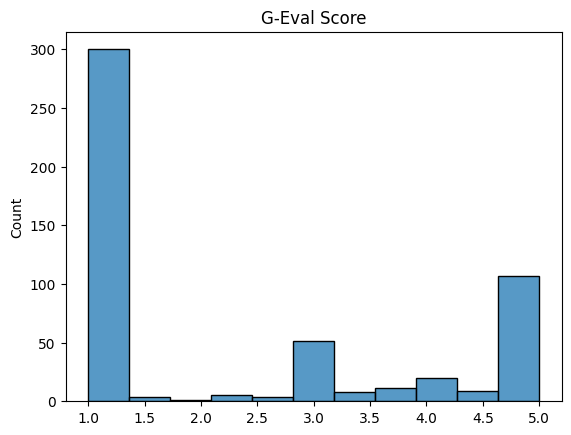

In [20]:
sns.histplot(data=score_lst)
plt.title("G-Eval Score")
plt.draw()